# PhyGNN Test with Pythagorean's Theorem

In this example test we create a dataset with pythagorean's theorem `a^2 + b^2 = c^2` where `a` and `b` are input features and we are trying to predict `c`. We train on a noisy and biased `c` dataset resulting in a predictably biased neural network. We then train with an augmented loss function that includes 80% weight on the predicted vs. physical calculation of `c`. The neural network loses its bias and is able to predict much more accurately. 

Obviously this is an idealized situation where we know the solution for `c`, but the physical loss function can be created using whatever benchmark might be applicable to a given physical domain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from phygnn import PhysicsGuidedNeuralNetwork

In [2]:
tf.__version__

'2.1.0'

# Pythag Inputs

Here we set up the training features and known output values based on the pythagorean theorem.

In [3]:
N = 100

a = np.linspace(-1, 1, N)
b = np.linspace(-1, 1, N)
a, b = np.meshgrid(a, b)

a = np.expand_dims(a.flatten(), axis=1)
b = np.expand_dims(b.flatten(), axis=1)

y = np.sqrt(a ** 2 + b ** 2)
x = np.hstack((a, b))
p = x.copy()

y.shape, x.shape, p.shape

((10000, 1), (10000, 2), (10000, 2))

Here we make a y_noise dataset which is noisy and systematically biased.

Text(0, 0.5, 'y_noise')

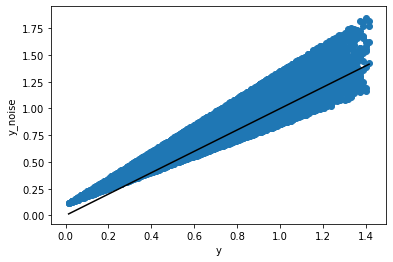

In [4]:
y_noise = y * (1 + (np.random.random(y.shape) - 0.5) * 0.5) + 0.1
plt.scatter(y, y_noise)
plt.plot((y.min(), y.max()), (y.min(), y.max()), 'k-')
plt.xlabel('y')
plt.ylabel('y_noise')

# Example P_Fun

This is an example physics loss function that supplements the normal y_predicted vs. y_true neural network loss function.

In [5]:
def p_fun_pythag(y_predicted, y_true, p):
    """Example function for loss calculation using physical relationships.
    
    Parameters
    ----------
    y_predicted : tf.Tensor
        Predicted y values in a 2D tensor based on x values in this batch.
    y_true : np.ndarray
        Known y values that were given to the PhyGNN fit method.
    p : np.ndarray
        Supplemental physical feature data that can be used to calculate a 
        y_physical value to compare against y_predicted. The rows in this 
        array have been carried through the batching process alongside y_true 
        and the features used to create y_predicted and so can be used 1-to-1 
        with the rows in y_predicted and y_true.
    
    Returns
    -------
    p_loss : tf.Tensor
        A 0D tensor physical loss value.
    """
    
    p = tf.convert_to_tensor(p, dtype=tf.float32)
    y_physical = tf.sqrt(p[:, 0]**2 + p[:, 1]**2)
    y_physical = tf.expand_dims(y_physical, 1)
    
    p_loss = tf.math.reduce_mean(tf.math.abs(y_predicted - y_physical))
    
    return p_loss

# NN Model Structure

Here we define the model layers using a simple list of kwargs.

In [6]:
hidden_layers = [{'units': 64, 'activation': 'relu', 'name': 'relu1'},
                 {'units': 64, 'activation': 'relu', 'name': 'relu2'},
                ]

# Train the Model without P_Fun

Here we train the model with loss weights (1.0, 0.0) which fully weights the mean absolute error of y_predicted vs. y_noise and does not weight the p_fun calculation at all.

In [7]:
PhysicsGuidedNeuralNetwork.seed(0)
model = PhysicsGuidedNeuralNetwork(p_fun=p_fun_pythag, 
                                   hidden_layers=hidden_layers, 
                                   loss_weights=(1.0, 0.0), 
                                   input_dims=2, output_dims=1)
model.fit(x, y_noise, p, n_batch=4, n_epoch=20)

Instructions for updating:
Use tf.identity instead.


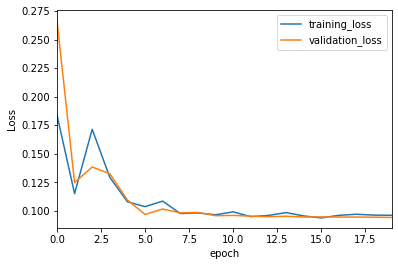

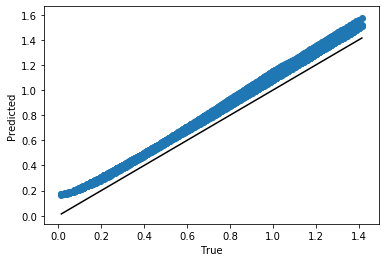

MAE: 0.102


In [8]:
model.history[['training_loss', 'validation_loss']].plot()
plt.ylabel('Loss')
plt.show()
plt.close()

y_pred = model.predict(x)
plt.scatter(y, y_pred)
plt.plot((y.min(), y.max()), (y.min(), y.max()), 'k-')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()
plt.close()
print('MAE: {:.3f}'.format(np.mean(np.abs(y_pred - y))))

# Train the Model with P_Fun

Here we train the model with loss weights (0.2, 0.8) which still weights the mean absolute error of y_predicted vs. y_noise but also gives much more weight to the p_fun calculation. We can see by the results that supplementing the pure NN training with a physical estimate of the true value helps the overall model prediction capabilities. 

In [9]:
PhysicsGuidedNeuralNetwork.seed(0)
model = PhysicsGuidedNeuralNetwork(p_fun=p_fun_pythag, 
                                   hidden_layers=hidden_layers, 
                                   loss_weights=(0.2, 0.8),
                                   input_dims=2, output_dims=1)
model.fit(x, y_noise, p, n_batch=4, n_epoch=20)

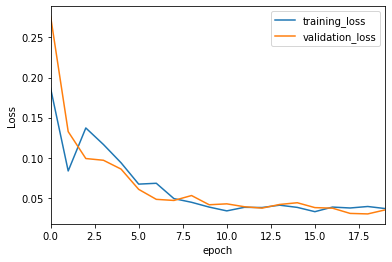

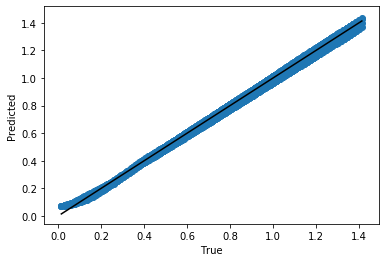

MAE: 0.012


In [10]:
model.history[['training_loss', 'validation_loss']].plot()
plt.ylabel('Loss')
plt.show()
plt.close()

y_pred = model.predict(x)
plt.scatter(y, y_pred)
plt.plot((y.min(), y.max()), (y.min(), y.max()), 'k-')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()
plt.close()
print('MAE: {:.3f}'.format(np.mean(np.abs(y_pred - y))))

# Bad Physics Function Test

Here we see that a p_fun input with numpy operations instead of tensorflow operations cannot be used in PhyGNN. This is because of how the stochastic gradient descent algorithm works in tensorflow. SGD finds the gradient of the loss with respect to the change in node weights. The loss function must be automatically differentiable for this to work. 

In [11]:
def p_fun_bad(y_predicted, y_true, p):
    """This is an example of a poorly formulated p_fun() that uses numpy operations."""
    
    y_physical = p[:, 0]**2 + p[:, 1]**2
    p_loss = np.mean(np.abs(y_predicted.numpy() - y_physical))
    p_loss = tf.convert_to_tensor(p_loss, dtype=tf.float32)
    
    return p_loss

In [12]:
PhysicsGuidedNeuralNetwork.seed(0)
model = PhysicsGuidedNeuralNetwork(p_fun=p_fun_bad, 
                                   hidden_layers=hidden_layers, 
                                   loss_weights=(0.5, 0.5),
                                   input_dims=2, output_dims=1)
model.fit(x, y_noise, p, n_batch=4, n_epoch=20)

The input p_fun was not differentiable! Please use only tensor math in the p_fun.


RuntimeError: The input p_fun was not differentiable! Please use only tensor math in the p_fun.